In [7]:
import json
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Set style
# sns.set_style("whitegrid")
# plt.rcParams['figure.figsize'] = (14, 8)
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.figsize": (16, 10),
    "font.family": "DejaVu Sans",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2.5,
})

# Directory containing the results
results_dir = "/home/drew99/School/MastersT/crewai-gym/pddl-llm/test_results"

# Find JSON files with matching txt files
json_files = glob.glob(os.path.join(results_dir, "all_results_*.json"))
txt_files = glob.glob(os.path.join(results_dir, "sum_results_*.txt"))

# Extract timestamps from txt files
txt_timestamps = set()
for txt_file in txt_files:
    timestamp = Path(txt_file).stem.replace("sum_results_", "")
    txt_timestamps.add(timestamp)

print(f"Found {len(txt_timestamps)} matching timestamps:")
for ts in sorted(txt_timestamps):
    print(f"  - {ts}")

# Filter JSON files to only those with matching timestamps
matching_json_files = []
for json_file in json_files:
    timestamp = Path(json_file).stem.replace("all_results_", "")
    if timestamp in txt_timestamps:
        matching_json_files.append(json_file)

print(f"\nFound {len(matching_json_files)} JSON files with matching timestamps")

# Load data from matching JSON files and exclude runs with "Max attempts reached"
all_data = []

for json_file in sorted(matching_json_files):
    timestamp = Path(json_file).stem.replace("all_results_", "")
    print(f"\nProcessing {Path(json_file).name}...")
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    for model_name, model_data in data.items():
        # # Check if this model run has any "Max attempts reached" errors
        # has_max_attempts_error = False
        
        # if 'results' in model_data and model_data['results']:
        #     for problem_name, problem_data in model_data['results'].items():
        #         if 'error' in problem_data and problem_data['error'] == "Max attempts reached":
        #             has_max_attempts_error = True
        #             break
        
        # if has_max_attempts_error:
        #     print(f"  Excluding {model_name} (has 'Max attempts reached' errors)")
        #     continue
        
        # Extract solved_at_k data
        if 'stats' in model_data and 'solved_at_k' in model_data['stats']:
            solved_at_k = model_data['stats']['solved_at_k']
            
            for k, solved_count in solved_at_k.items():
                all_data.append({
                    'model': model_name.split("/")[-1],
                    'k': int(k),
                    'solved_count': solved_count,
                    'timestamp': timestamp
                })
            print(f"  ✓ Included {model_name}")

print(f"\nTotal data points: {len(all_data)}")

# Create DataFrame
df = pd.DataFrame(all_data)
print(f"\nUnique models: {df['model'].nunique()}")
print(f"Models: {sorted(df['model'].unique())}")


Found 10 matching timestamps:
  - 20251008_233140
  - 20251009_085127
  - 20251009_154950
  - 20251011_230439
  - 20251012_103934
  - 20251222_174414_tmp
  - 20251222_221155
  - 20251223_005417_tmp
  - 20251223_083802_tmp
  - 20251223_095359

Found 10 JSON files with matching timestamps

Processing all_results_20251008_233140.json...
  ✓ Included openai/gpt-4o
  ✓ Included openai/o1-mini*
  ✓ Included openai/gpt-4-0125-preview*

Processing all_results_20251009_085127.json...
  ✓ Included openai/gpt-5
  ✓ Included openai/gpt-5-mini
  ✓ Included openai/o3
  ✓ Included openai/gpt-4.1
  ✓ Included openai/o4-mini

Processing all_results_20251009_154950.json...
  ✓ Included openai/gpt-4o
  ✓ Included openai/o1-mini*
  ✓ Included openai/gpt-4-0125-preview*
  ✓ Included openai/gpt-5
  ✓ Included openai/gpt-5-mini

Processing all_results_20251011_230439.json...
  ✓ Included openai/o3
  ✓ Included openai/gpt-4.1
  ✓ Included openai/o4-mini

Processing all_results_20251012_103934.json...
  ✓ Incl

In [8]:
# Exclude deprecated/failed models
excluded_models = ['o1-mini*']

print(f"Before filtering: {len(df)} data points, {df['model'].nunique()} models")
print(f"Excluding models: {excluded_models}")

df = df[~df['model'].isin(excluded_models)]

print(f"After filtering: {len(df)} data points, {df['model'].nunique()} models")
print(f"Remaining models: {sorted(df['model'].unique())}")


Before filtering: 400 data points, 8 models
Excluding models: ['o1-mini*']
After filtering: 350 data points, 7 models
Remaining models: ['gpt-4-0125-preview*', 'gpt-4.1', 'gpt-4o', 'gpt-5', 'gpt-5-mini', 'o3', 'o4-mini']


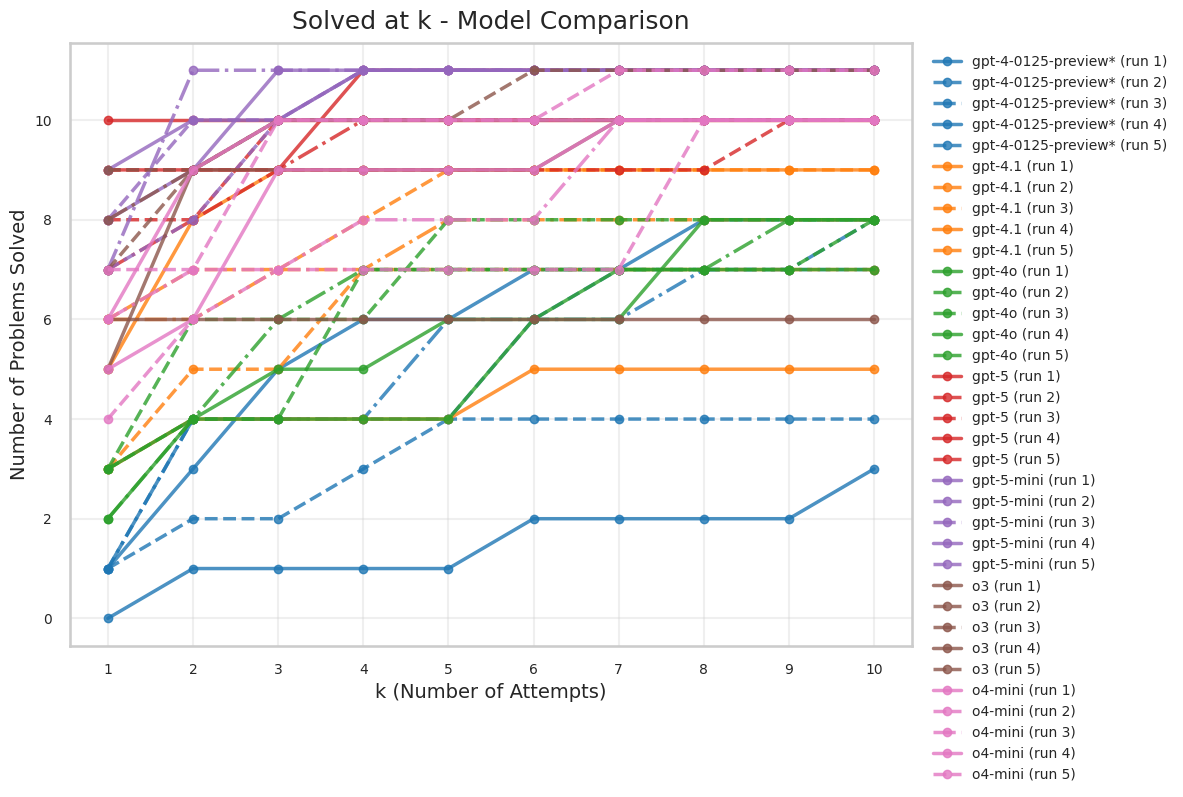


Plot saved to: /home/drew99/School/MastersT/crewai-gym/pddl-llm/test_results/solved_at_k_comparison.pdf


In [9]:
# Create a palette with different colors for each model
unique_models = sorted(df['model'].unique())
n_models = len(unique_models)

# Use a color palette with distinct colors
palette = sns.color_palette("tab10", n_colors=n_models)
model_colors = {model: palette[i] for i, model in enumerate(unique_models)}

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each model-timestamp combination
for model in unique_models:
    model_df = df[df['model'] == model]
    
    # Get unique timestamps for this model (these will be the different lines with same color)
    timestamps = sorted(model_df['timestamp'].unique())
    
    for i, timestamp in enumerate(timestamps):
        timestamp_df = model_df[model_df['timestamp'] == timestamp].sort_values('k')
        
        # Use different line styles for different runs of the same model
        linestyles = ['-', '--', '-.']
        linestyle = linestyles[i % len(linestyles)]
        
        # Add run number to label if there are multiple runs
        if len(timestamps) > 1:
            label = f"{model} (run {i+1})"
        else:
            label = model
        
        plt.plot(timestamp_df['k'], timestamp_df['solved_count'], 
                color=model_colors[model], 
                linestyle=linestyle,
                linewidth=2.5,
                marker='o',
                markersize=6,
                label=label,
                alpha=0.8)

plt.xlabel('k (Number of Attempts)', fontsize=14)#, fontweight='bold')
plt.ylabel('Number of Problems Solved', fontsize=14)#, fontweight='bold')
plt.title('Solved at k - Model Comparison', # (Excluding runs with "Max attempts reached")', 
          fontsize=18, pad=10)#, fontweight='bold', pad=20)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
# plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Set x-axis to show integers only
plt.xticks(range(1, 11))

plt.savefig(os.path.join(results_dir, 'solved_at_k_comparison.pdf'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {os.path.join(results_dir, 'solved_at_k_comparison.pdf')}")


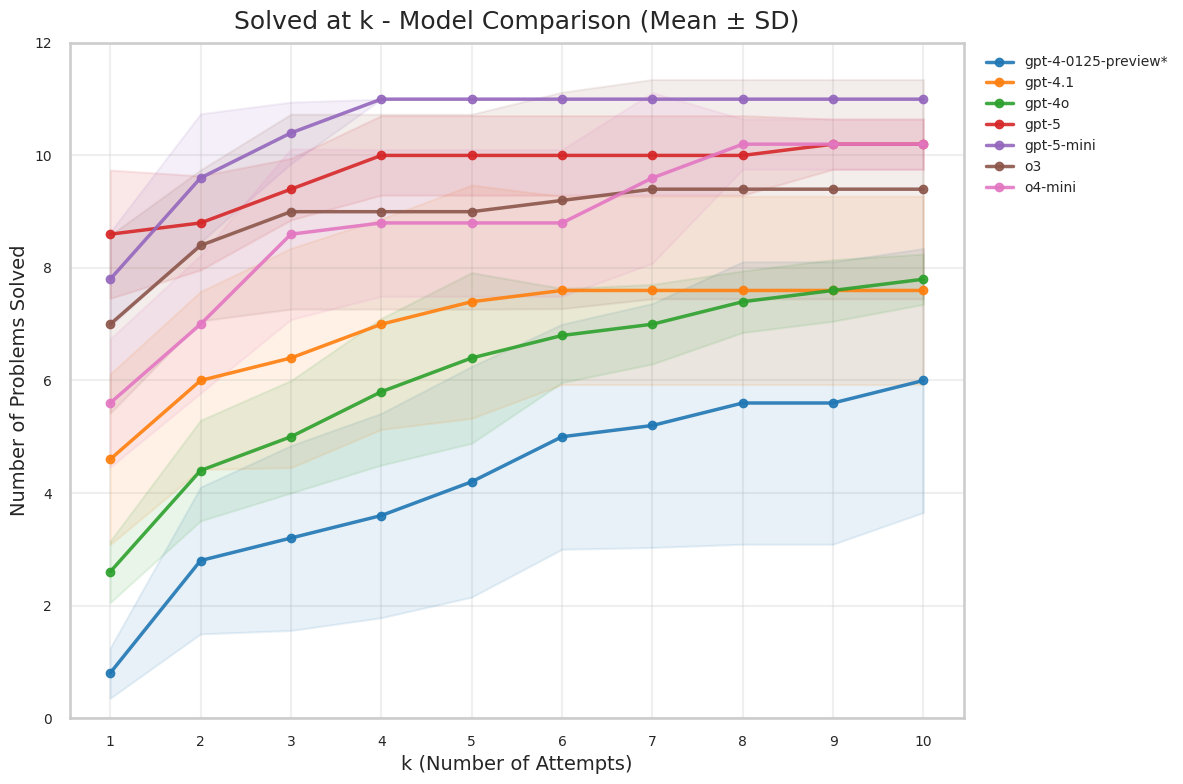


Plot saved to: /home/drew99/School/MastersT/crewai-gym/pddl-llm/test_results/solved_at_k_mean_sd.pdf


In [13]:
# Solved at k - Mean ± SD plot

# Calculate mean and std for each model at each k
mean_std_df = df.groupby(['model', 'k']).agg(
    mean_solved=('solved_count', 'mean'),
    std_solved=('solved_count', 'std'),
    n_runs=('solved_count', 'count')
).reset_index()

# Fill NaN std with 0 (happens when only 1 run exists)
mean_std_df['std_solved'] = mean_std_df['std_solved'].fillna(0)

# Create color palette
unique_models = sorted(df['model'].unique())
n_models = len(unique_models)
palette = sns.color_palette("tab10", n_colors=n_models)
model_colors = {model: palette[i] for i, model in enumerate(unique_models)}

# Create the plot
plt.figure(figsize=(12, 8))

for model in unique_models:
    model_data = mean_std_df[mean_std_df['model'] == model].sort_values('k')
    
    k_vals = model_data['k'].values
    mean_vals = model_data['mean_solved'].values
    std_vals = model_data['std_solved'].values
    
    color = model_colors[model]
    
    # Plot mean line with markers
    plt.plot(k_vals, mean_vals, 
             color=color, 
             linewidth=2.5,
             marker='o',
             markersize=6,
             label=model,
             alpha=0.9)
    
    # Plot shaded std region
    plt.fill_between(k_vals, 
                     mean_vals - std_vals, 
                     mean_vals + std_vals, 
                     color=color, 
                     alpha=0.1)

plt.xlabel('k (Number of Attempts)', fontsize=14)
plt.ylabel('Number of Problems Solved', fontsize=14)
plt.title('Solved at k - Model Comparison (Mean ± SD)', fontsize=18, pad=10)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Set x-axis to show integers only
plt.xticks(range(1, 11))

# Set y-axis limits
plt.ylim(0, 12)

plt.savefig(os.path.join(results_dir, 'solved_at_k_mean_sd.pdf'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {os.path.join(results_dir, 'solved_at_k_mean_sd.pdf')}")


In [14]:
# Summary statistics by model
print("="*80)
print("Summary by Model")
print("="*80)

for model in unique_models:
    model_df = df[df['model'] == model]
    timestamps = sorted(model_df['timestamp'].unique())
    
    print(f"\n{model}:")
    print(f"  Number of runs: {len(timestamps)}")
    print(f"  Timestamps: {', '.join(timestamps)}")
    
    # Show final solved count (at k=10) for each run
    for timestamp in timestamps:
        final_solved = model_df[(model_df['timestamp'] == timestamp) & (model_df['k'] == 10)]['solved_count'].values
        if len(final_solved) > 0:
            print(f"    {timestamp}: {final_solved[0]} problems solved at k=10")

print("\n" + "="*80)


Summary by Model

gpt-4-0125-preview*:
  Number of runs: 5
  Timestamps: 20251008_233140, 20251009_154950, 20251012_103934, 20251222_174414_tmp, 20251223_005417_tmp
    20251008_233140: 3 problems solved at k=10
    20251009_154950: 4 problems solved at k=10
    20251012_103934: 8 problems solved at k=10
    20251222_174414_tmp: 8 problems solved at k=10
    20251223_005417_tmp: 7 problems solved at k=10

gpt-4.1:
  Number of runs: 5
  Timestamps: 20251009_085127, 20251011_230439, 20251012_103934, 20251222_221155, 20251223_083802_tmp
    20251009_085127: 9 problems solved at k=10
    20251011_230439: 7 problems solved at k=10
    20251012_103934: 8 problems solved at k=10
    20251222_221155: 5 problems solved at k=10
    20251223_083802_tmp: 9 problems solved at k=10

gpt-4o:
  Number of runs: 5
  Timestamps: 20251008_233140, 20251009_154950, 20251012_103934, 20251222_174414_tmp, 20251223_005417_tmp
    20251008_233140: 8 problems solved at k=10
    20251009_154950: 8 problems solved 

In [18]:
# Calculate average metrics per model across all runs

# First, need to load the full data with stats to get avg_attempts
model_stats = []

for json_file in sorted(matching_json_files):
    timestamp = Path(json_file).stem.replace("all_results_", "")
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    for model_name, model_data in data.items():
        # Check if this model run has any "Max attempts reached" errors
        has_max_attempts_error = False
        
        if 'results' in model_data and model_data['results']:
            for problem_name, problem_data in model_data['results'].items():
                if 'error' in problem_data and problem_data['error'] == "Max attempts reached":
                    has_max_attempts_error = True
                    break
        
        if has_max_attempts_error:
            continue
        
        # Extract stats
        if 'stats' in model_data:
            stats = model_data['stats']
            
            # Get solved at k=10
            solved_at_10 = stats.get('solved_at_k', {}).get('10', 0) if 'solved_at_k' in stats else 0
            total_problems = stats.get('total_problems', 11)
            percent_solved = (solved_at_10 / total_problems * 100) if total_problems > 0 else 0
            avg_attempts = stats.get('avg_attempts', 0)
            
            model_stats.append({
                'model': model_name.split("/")[-1],
                'timestamp': timestamp,
                'percent_solved_at_10': percent_solved,
                'avg_attempts': avg_attempts,
                'solved_at_10': solved_at_10,
                'total_problems': total_problems
            })

# Create DataFrame
stats_df = pd.DataFrame(model_stats)

# Calculate averages per model
model_avg = stats_df.groupby('model').agg({
    'percent_solved_at_10': 'mean',
    'avg_attempts': 'mean',
    'solved_at_10': 'mean'
}).reset_index()

model_avg = model_avg.sort_values('percent_solved_at_10', ascending=False)

print("\nModel Averages:")
print(model_avg)



Model Averages:
                 model  percent_solved_at_10  avg_attempts  solved_at_10
4           gpt-5-mini            100.000000      1.472727     11.000000
7              o4-mini             95.454545      2.422727     10.250000
3                gpt-5             93.939394      1.648485     10.333333
6                   o3             90.909091      1.650000     10.000000
1              gpt-4.1             77.272727      1.652778      8.500000
5             o1-mini*             77.272727      3.263889      8.500000
2               gpt-4o             72.727273      3.250000      8.000000
0  gpt-4-0125-preview*             54.545455      3.062500      6.000000


In [19]:
# remove o1-mini*
model_avg = model_avg[~model_avg['model'].str.contains('o1-mini')]



Bar plot saved to: /home/drew99/School/MastersT/crewai-gym/pddl-llm/test_results/percent_solved_with_attempts.pdf


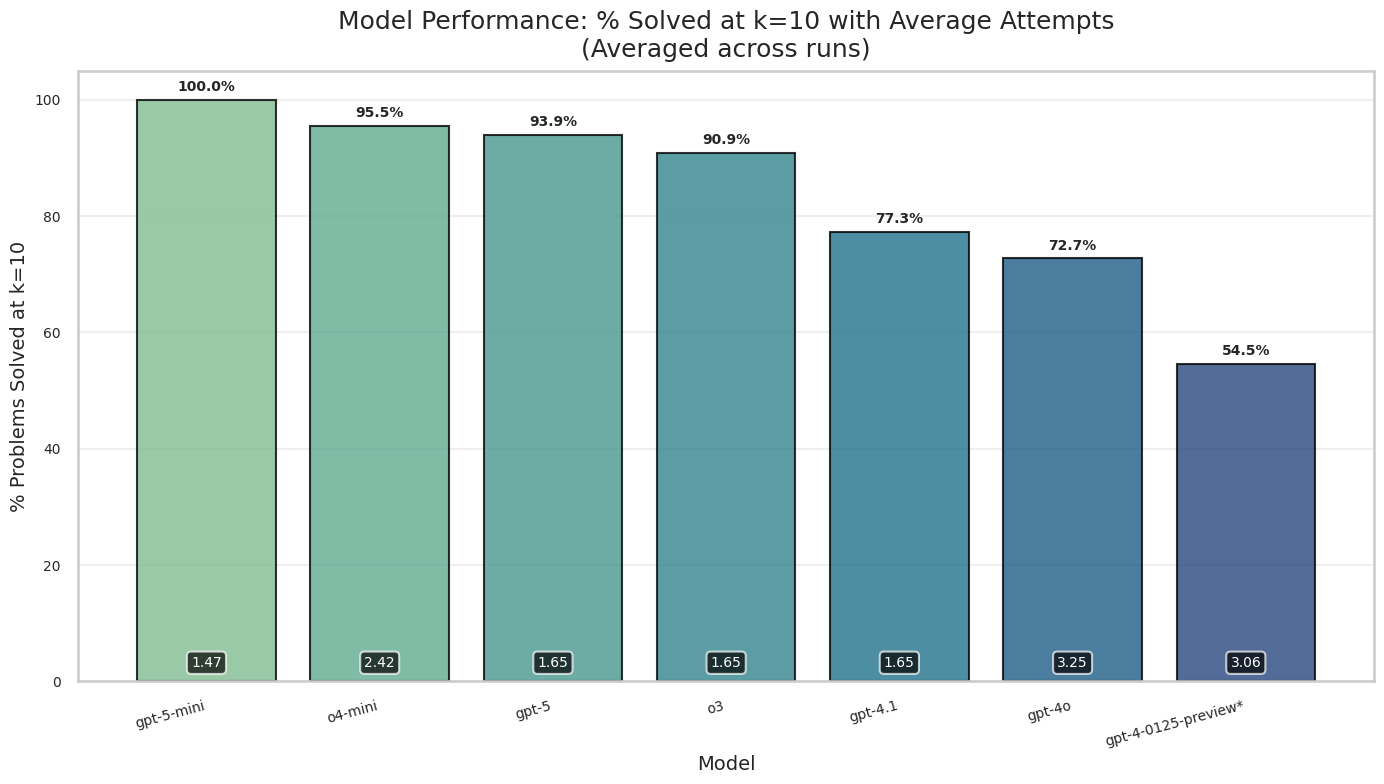

In [20]:
# Create bar plot for % solved at k=10 with average attempts shown

plt.figure(figsize=(14, 8))

# Create color palette for models
n_models_avg = len(model_avg)
colors = sns.color_palette("crest", n_colors=n_models_avg)

# Create bar plot
bars = plt.bar(range(len(model_avg)), model_avg['percent_solved_at_10'], 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add average attempts as text at the bottom of each bar
for i, (idx, row) in enumerate(model_avg.iterrows()):
    # Add text inside the bar at the bottom
    plt.text(i, 2, f"{row['avg_attempts']:.2f}", 
             ha='center', va='bottom', fontsize=10, color='white',  # fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    # Also add percentage on top of the bar
    plt.text(i, row['percent_solved_at_10'] + 1, f"{row['percent_solved_at_10']:.1f}%", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize plot
plt.xlabel('Model', fontsize=14)#, fontweight='bold')
plt.ylabel('% Problems Solved at k=10', fontsize=14)#, fontweight='bold')
plt.title('Model Performance: % Solved at k=10 with Average Attempts\n(Averaged across runs)', #, excluding "Max attempts reached")', 
          fontsize=18, pad=10) #, fontweight='bold')

# Set x-axis labels
plt.xticks(range(len(model_avg)), model_avg['model'], rotation=15, ha='right', fontsize=10)

# Add grid
plt.grid(True, alpha=0.3, axis='y')
plt.grid(False, axis='x')

# Set y-axis to go from 0 to 100
plt.ylim(0, 105)

plt.tight_layout()

# Save the plot
output_path_bar = os.path.join(results_dir, 'percent_solved_with_attempts.pdf')
plt.savefig(output_path_bar, dpi=300, bbox_inches='tight')
print(f"\nBar plot saved to: {output_path_bar}")

plt.show()


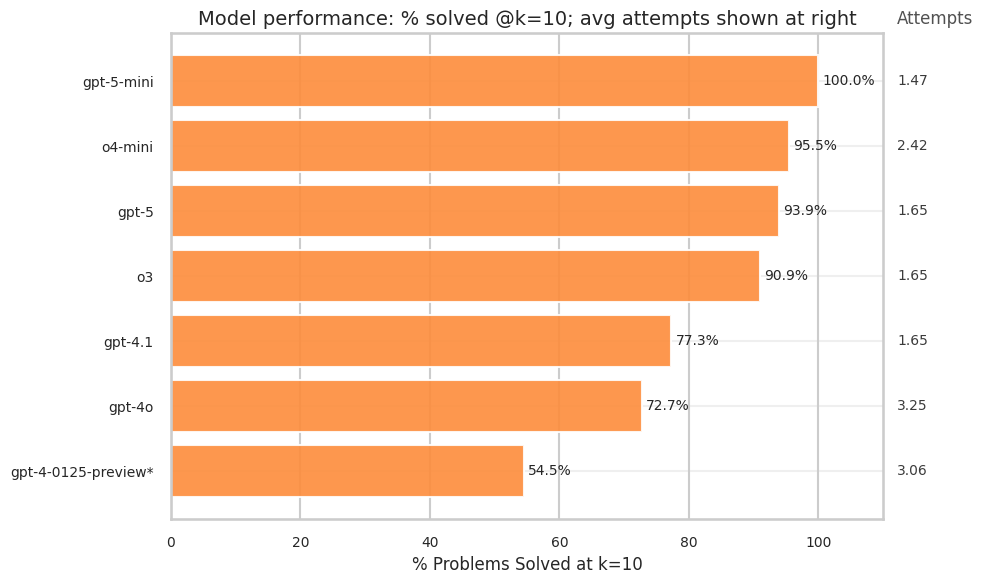

In [21]:
# assume model_avg has columns: model, percent_solved_at_10, avg_attempts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = model_avg.sort_values('percent_solved_at_10', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
c = sns.color_palette("Oranges", n_colors=3)[1]
bars = ax.barh(df['model'], df['percent_solved_at_10'], color=c, alpha=0.9)

# # % labels at bar ends
# ax.bar_label(bars, labels=[f"{v:.1f}%" for v in df['percent_solved_at_10']], padding=3, fontsize=10)

# # attempts as a clean right column
# for y, att in enumerate(df['avg_attempts']):
#     ax.text(df['percent_solved_at_10'].max() + 2, y, f"{att:.2f}", va='center', fontsize=10, alpha=0.9)

# ax.set_xlabel('% Problems Solved at k=10')
# ax.set_ylabel('')
# ax.set_xlim(0, max(100, df['percent_solved_at_10'].max() + 10))
# ax.set_title('Model performance: % solved @k=10; avg attempts shown at right')
# # subtle grid
# ax.xaxis.grid(True, alpha=0.3)
# plt.tight_layout()


# % labels at bar ends (keep as-is)
ax.bar_label(bars, labels=[f"{v:.1f}%" for v in df['percent_solved_at_10']],
             padding=3, fontsize=10)

# Attempts as a right-side column (axes coords, won’t overlap)
for bar, att in zip(bars, df['avg_attempts']):
    y = bar.get_y() + bar.get_height()/2
    ax.text(1.02, y, f"{att:.2f}",
            transform=ax.get_yaxis_transform(),  # x in [0,1] w.r.t. axes
            va='center', ha='left', fontsize=10, alpha=0.9, clip_on=False)

# Optional small column header
ax.text(1.02, 1.01, "Attempts", transform=ax.transAxes, ha='left', va='bottom', fontsize=12, alpha=0.8)

# Make room on the right so text isn’t clipped
plt.subplots_adjust(right=0.85)

ax.set_xlabel('% Problems Solved at k=10', fontsize=12)
ax.set_ylabel('')
ax.set_xlim(0, max(100, df['percent_solved_at_10'].max() + 10))
ax.set_title('Model performance: % solved @k=10; avg attempts shown at right', fontsize=14)
ax.yaxis.grid(True, alpha=0.3)
plt.tight_layout()